In [183]:
import pandas as pd
import numpy as np
#from pennylane import numpy as np
import pennylane as qml
from pennylane_qiskit import IBMQDevice
from pennylane_qiskit import BasicAerDevice
from pennylane.templates.embeddings import AngleEmbedding, AmplitudeEmbedding
from pennylane.optimize import AdamOptimizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import normalize
from skpp import ProjectionPursuitRegressor


import time
start = time.time()

import warnings
warnings.filterwarnings('ignore')

In [184]:
# Dataset CSV load
df = pd.read_csv('fraud_detection_bank_dataset.csv', sep=',')

# Data type definition as float
df = df.astype(float)

# Drop of columns if necessary
df = df.drop(['Unnamed: 0'], axis = 1)

# Sample selection
df_sample = df.sample(1000)

In [185]:
# Review the information related to the dataframe

df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 8912 to 5204
Columns: 113 entries, col_0 to targets
dtypes: float64(113)
memory usage: 890.6 KB


In [186]:
# Table of the description of the dataframe related to fixed parameters

df_sample.describe()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_103,col_104,col_105,col_106,col_107,col_108,col_109,col_110,col_111,targets
count,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0,1000.0,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.635000,267.685000,0.372000,2.01500,0.084000,0.784000,2.367000,2.635000,0.0,0.0,...,0.005000,0.359000,0.003000,0.303000,0.186000,0.001000,0.047000,0.021000,41.659000,0.274000
std,11.759254,692.297183,2.610063,6.97032,0.466006,1.796266,2.999218,11.759254,0.0,0.0,...,0.070569,0.479947,0.054717,0.459785,0.389301,0.031623,0.211745,0.224966,53.091915,0.446232
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,-1.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,36.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000
50%,0.000000,96.000000,0.000000,1.00000,0.000000,0.000000,2.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.500000,0.000000
75%,1.000000,239.250000,0.000000,2.00000,0.000000,1.000000,6.000000,1.000000,0.0,0.0,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,60.000000,1.000000
max,234.000000,9319.000000,48.000000,183.00000,9.000000,38.000000,8.000000,234.000000,0.0,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,485.000000,1.000000


In [187]:
# Train, test and validation split
train = df_sample.sample(frac = 0.7)
test = df_sample.drop(train.index)
#validate = df_sample.drop(train.index).drop(test.index)

In [188]:
train.shape

(700, 113)

In [189]:
test.shape

(300, 113)

In [190]:
validate.shape

(150, 113)

In [191]:
# Separation of labels
x_train = train
y_train = train[['targets']]
x_test = test
y_test = test[['targets']]
#x_validate = validate
#y_validate = validate[['targets']]

In [192]:
x_train = x_train.drop(['targets'], axis = 1)
x_test = x_test.drop(['targets'], axis = 1)
#x_validate = x_validate.drop(['targets'], axis = 1)

In [193]:
x_train == 0

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_102,col_103,col_104,col_105,col_106,col_107,col_108,col_109,col_110,col_111
5154,True,False,True,False,True,False,False,True,True,True,...,True,True,True,True,True,True,True,True,True,False
94,False,False,False,True,False,True,False,False,True,True,...,True,True,False,True,True,True,True,False,True,False
20020,False,False,True,False,True,True,False,False,True,True,...,False,True,True,True,True,True,True,True,True,False
15278,True,False,False,True,True,True,False,True,True,True,...,False,True,False,True,False,False,True,True,True,False
8116,True,False,True,True,False,True,False,True,True,True,...,True,True,False,True,True,True,True,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6683,False,False,True,False,True,False,False,False,True,True,...,False,True,True,True,False,True,True,True,True,False
6898,True,False,True,False,True,True,False,True,True,True,...,False,True,True,True,True,True,True,True,True,False
13819,True,False,True,False,True,True,False,True,True,True,...,False,True,True,True,True,True,True,True,True,False
10367,True,False,False,True,True,True,False,True,True,True,...,True,True,True,True,True,True,True,True,True,False


In [194]:
(x_train == 0).all()

col_0      False
col_1      False
col_2      False
col_3      False
col_4      False
           ...  
col_107    False
col_108     True
col_109    False
col_110    False
col_111    False
Length: 112, dtype: bool

In [195]:
drop_0 = x_train.columns[(x_train == 0).all()]

In [196]:
drop_0

Index(['col_8', 'col_9', 'col_10', 'col_11', 'col_12', 'col_18', 'col_19',
       'col_20', 'col_21', 'col_35', 'col_39', 'col_40', 'col_51', 'col_52',
       'col_53', 'col_58', 'col_70', 'col_71', 'col_78', 'col_91', 'col_93',
       'col_108'],
      dtype='object')

In [197]:
corr_matrix = x_train.corr().abs()

In [198]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [199]:
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [200]:
to_drop

['col_7', 'col_22', 'col_54', 'col_61']

In [201]:
x_train.drop(['col_8', 'col_9', 'col_10', 'col_11', 'col_12', 'col_18', 'col_19','col_20', 'col_21', 'col_35', 'col_51', 'col_52', 'col_53', 'col_70','col_71','col_7', 'col_22', 'col_54', 'col_56'], axis = 1)
x_test.drop(['col_8', 'col_9', 'col_10', 'col_11', 'col_12', 'col_18', 'col_19','col_20', 'col_21', 'col_35', 'col_51', 'col_52', 'col_53', 'col_70','col_71','col_7', 'col_22', 'col_54', 'col_56'], axis = 1)
x_validate.drop(['col_8', 'col_9', 'col_10', 'col_11', 'col_12', 'col_18', 'col_19','col_20', 'col_21', 'col_35', 'col_51', 'col_52', 'col_53', 'col_70','col_71','col_7', 'col_22', 'col_54', 'col_56'], axis = 1)

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_13,col_14,col_15,...,col_102,col_103,col_104,col_105,col_106,col_107,col_108,col_109,col_110,col_111
9033,1.0,109.0,0.0,5.0,0.0,0.0,2.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0
4901,0.0,10.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,65.0
3139,0.0,29.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10730,0.0,13.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
18971,9.0,309.0,3.0,1.0,0.0,0.0,-1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4531,0.0,99.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,40.0
10515,0.0,79.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12659,0.0,109.0,0.0,3.0,0.0,0.0,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,20.0
4623,1.0,341.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0


In [202]:
skpp = ProjectionPursuitRegressor(r=2, fit_type='spline').fit(x_train, y_train)

In [203]:
# LDA validate transformation (using train fit)
x_train_skpp = skpp.transform(x_train)
x_test_skpp = skpp.transform(x_test)

In [204]:
# Arrays to dataframe for join in a single df
x_train_skpp = pd.DataFrame(x_train_skpp)
x_test_skpp = pd.DataFrame(x_test_skpp)

In [205]:
# Second standard scaler normalization (using train fit)
std_scale = StandardScaler().fit(x_train_skpp)
data = std_scale.transform(x_train_skpp)
x_test_lda_n = std_scale.transform(x_test_skpp)
#x_validate_lda_n = std_scale.transform(x_validate_skpp)

In [206]:
# Dimensions definition for QML
n_dim = len(x_train_skpp.columns)
n_dim

2

In [207]:
# Review the balance of the target variable in train

y_train.value_counts(normalize=True)*100

targets
0.0        72.285714
1.0        27.714286
dtype: float64

In [208]:
# Review the balance of the target variable in test

y_test.value_counts(normalize=True)*100

targets
0.0        73.333333
1.0        26.666667
dtype: float64

In [209]:
# Begin of Pennylane variational classifier

In [210]:
from pennylane import numpy as np

In [211]:
# Angle Encoding
num_qubits = n_dim

# Device seletion
dev = qml.device('default.qubit', wires = num_qubits, shots=1024)
#dev = qml.device('lightning.qubit',wires=1)
#dev = qml.device('default.qubit.tf', wires = num_qubits, shots=1024)
#dev = qml.device('qiskit.ibmq', wires = num_qubits, backend='ibmq_manila', ibmqx_token="6cc75c58fc80fea56cb8dd391f8fbcfdb676a3dc7005493728bc9da7ea753e31a2110a01e3a0cc83f1a98f5ca79e32956fc66c11b5eea4cae163b3fa996be356", shots=256)
#dev = qml.device('qiskit.basicaer', wires = num_qubits, shots = 256)

@qml.qnode(dev)
def circuit(parameters, data):
    for i in range(num_qubits):
        qml.Hadamard(wires = i)
    
    AngleEmbedding(features = data, wires = range(num_qubits), rotation = 'Y')
    
    qml.StronglyEntanglingLayers(weights = parameters, wires = range(num_qubits))
    
    return qml.expval(qml.PauliZ(0))

In [212]:
num_layers = 5
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print(weights_init, bias_init)

[[[-3.22670552e-03 -1.07100838e-02 -1.28722659e-03]
  [ 9.31083045e-03  8.09626772e-03 -1.08806313e-02]]

 [[ 1.76780686e-02 -1.85177689e-02  2.79278253e-03]
  [-1.42404580e-02  1.15278274e-02 -6.16505446e-03]]

 [[ 4.86041831e-03 -5.22699780e-03  9.15000609e-03]
  [ 8.21095090e-03  1.32754053e-02 -9.95269171e-03]]

 [[ 4.15453097e-03  1.13071398e-02 -4.42821579e-03]
  [ 6.36920817e-04 -9.89950779e-03 -3.38427651e-03]]

 [[-2.36630327e-03  1.74899636e-02  6.79042991e-05]
  [ 1.15500310e-04  1.69366437e-02 -5.46363156e-03]]] 0.0


In [213]:
circuit(weights_init, data[0])

tensor(-0.20703125, requires_grad=True)

In [214]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

In [215]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [216]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [217]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

In [218]:
Y = np.array(y_train.values[:,0] * 2 - np.ones(len(y_train.values[:,0])), requires_grad = False)  # shift label from {0, 1} to {-1, 1}
X = np.array(data, requires_grad=False)

for i in range(5):
    print("X = {}, Y = {: d}".format(list(X[i]), int(Y[i])))

X = [tensor(-0.82001632, requires_grad=False), tensor(0.23429635, requires_grad=False)], Y =  1
X = [tensor(-0.98184432, requires_grad=False), tensor(0.16750821, requires_grad=False)], Y =  1
X = [tensor(0.3377696, requires_grad=False), tensor(-0.38331004, requires_grad=False)], Y = -1
X = [tensor(1.70523133, requires_grad=False), tensor(1.20413485, requires_grad=False)], Y = -1
X = [tensor(-0.6980282, requires_grad=False), tensor(-0.27874216, requires_grad=False)], Y = -1


In [219]:
opt = AdamOptimizer(stepsize=0.1, beta1=0.9, beta2=0.99, eps=1e-08)
batch_size = 10

In [220]:
weights = weights_init
bias = bias_init

wbest = 0
bbest = 0
abest = 0

for it in range(20):

    # weights update by one optimizer step

    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute the accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
    
    if accuracy(Y, predictions) > abest:
        wbest = weights
        bbest = bias
        abest = accuracy(Y, predictions)
        print('New best')

    acc = accuracy(Y, predictions)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), acc
        )
    )

New best
Iter:     1 | Cost: 0.7722841 | Accuracy: 0.7157143 
New best
Iter:     2 | Cost: 0.6712983 | Accuracy: 0.7357143 
New best
Iter:     3 | Cost: 0.6190105 | Accuracy: 0.7457143 
New best
Iter:     4 | Cost: 0.5452505 | Accuracy: 0.8014286 
New best
Iter:     5 | Cost: 0.5651728 | Accuracy: 0.8185714 
New best
Iter:     6 | Cost: 0.5162663 | Accuracy: 0.8585714 
New best
Iter:     7 | Cost: 0.4820346 | Accuracy: 0.8771429 
Iter:     8 | Cost: 0.4716927 | Accuracy: 0.8471429 
Iter:     9 | Cost: 0.4767313 | Accuracy: 0.8400000 
Iter:    10 | Cost: 0.4972898 | Accuracy: 0.8271429 
Iter:    11 | Cost: 0.5203754 | Accuracy: 0.7971429 
Iter:    12 | Cost: 0.5550295 | Accuracy: 0.7500000 
Iter:    13 | Cost: 0.5444372 | Accuracy: 0.7514286 
Iter:    14 | Cost: 0.5009727 | Accuracy: 0.8428571 
New best
Iter:    15 | Cost: 0.5475504 | Accuracy: 0.8957143 
Iter:    16 | Cost: 0.5252286 | Accuracy: 0.8900000 
Iter:    17 | Cost: 0.4738357 | Accuracy: 0.8957143 
Iter:    18 | Cost: 0.47902

In [221]:
# Testing set preparation
Yte = np.array(y_test.values[:,0] * 2 - np.ones(len(y_test.values[:,0])), requires_grad = False)
Xte = np.array(normalize(x_test_lda_n), requires_grad=False)

In [222]:
# Outcome on test set
predictions = [np.sign(variational_classifier(wbest, bbest, x)) for x in Xte]
pred = [np.sign(variational_classifier(wbest, bbest, x)) for x in X]
acc = accuracy(Yte, predictions)

print(f'Cost: {cost(wbest, bbest, Xte, Yte)}, Accuracy: {np.round(acc, 2) * 100}%')

Cost: 0.6148822025971983, Accuracy: 79.0%


In [223]:
# Test and predictions comparison
pd.DataFrame((Yte, predictions), ('Test', 'Predictions')).T

,Test,Predictions
0,-1.0,-1.0
1,-1.0,-1.0
2,-1.0,-1.0
3,-1.0,-1.0
4,-1.0,1.0
...,...,...
295,-1.0,-1.0
296,-1.0,-1.0
297,1.0,-1.0
298,-1.0,-1.0


In [224]:
# Print the classification report and important metrics
print(metrics.classification_report(Yte, predictions))
print(metrics.precision_score(Yte, predictions))
print(metrics.recall_score(Yte, predictions))
print(metrics.f1_score(Yte, predictions))
print(metrics.balanced_accuracy_score(Yte, predictions))

              precision    recall  f1-score   support

        -1.0       0.91      0.80      0.85       220
         1.0       0.58      0.78      0.66        80

    accuracy                           0.79       300
   macro avg       0.74      0.79      0.76       300
weighted avg       0.82      0.79      0.80       300

0.5794392523364486
0.775
0.6631016042780749
0.7852272727272727


In [225]:
# Get the predictions based on the optimized weights and bias
final_predictions = [variational_classifier(weights, bias, x) for x in Xte]
# Get the predictions within the range 0-1 so that they represent a probability
probability_class0 = (final_predictions-bias + np.ones(len(final_predictions)))/2
#probability_class0 = (predictions + np.ones(len(predictions)))/2

# Print the probability for each sample
print(probability_class0)

[0.16503906 0.34960938 0.21875    0.49609375 0.73242188 0.18261719
 0.21777344 0.21777344 0.35644531 0.76757812 0.10742188 0.25097656
 0.08398438 0.19335938 0.52148438 0.17675781 0.09765625 0.57714844
 0.74316406 0.52636719 0.0703125  0.703125   0.50585938 0.5625
 0.09082031 0.09375    0.51953125 0.36914062 0.09863281 0.20996094
 0.76953125 0.64550781 0.11328125 0.55175781 0.52246094 0.74609375
 0.18457031 0.46777344 0.46484375 0.68554688 0.67285156 0.71679688
 0.75292969 0.56738281 0.10644531 0.75585938 0.58300781 0.12890625
 0.3046875  0.24316406 0.60058594 0.57714844 0.22363281 0.65332031
 0.67089844 0.47363281 0.56738281 0.59375    0.69433594 0.21289063
 0.10253906 0.2578125  0.09863281 0.22753906 0.37011719 0.29492188
 0.22265625 0.10449219 0.14550781 0.19140625 0.41796875 0.10644531
 0.7265625  0.37988281 0.74121094 0.29589844 0.09570313 0.12695313
 0.75292969 0.18261719 0.27246094 0.3671875  0.09082031 0.61816406
 0.36621094 0.28320312 0.46582031 0.10058594 0.6015625  0.10449219

In [226]:
probability_class_0 = pd.DataFrame(probability_class0)

In [227]:
print(probability_class_0)

            0
0    0.165039
1    0.349609
2    0.218750
3    0.496094
4    0.732422
..        ...
295  0.336914
296  0.336914
297  0.091797
298  0.377930
299  0.756836

[300 rows x 1 columns]


In [228]:
decision = pd.DataFrame((predictions, Yte), ('Predictions', 'Test')).T

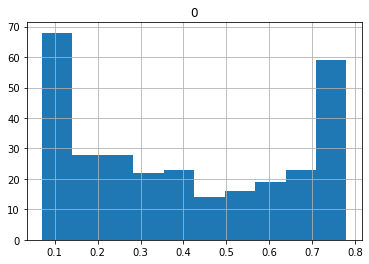

In [231]:
hist = probability_class_0.hist(bins=10)